# Tutorial 6 - A Simple Model of Vortex Shedding

In this tutorial, we'll take a look at animating a simple model of vortex shedding.

## Attached Vortexes

The phenomenon we want to model happens with high Reynolds number flow past an object (e.g., a cylinder); vortexes build up on the trailing side of the object and, at very high Reynolds number, detach and are carried downstream.  Under some conditions, this process can repeat regularly and form a *vortex street*.

Here, we're interested in the first part of this process, where vortexes form and are approximately steady, as can be seen here:

![Vortexes at the trailing edge of a circular cylinder](CylinderImage.jpg)

Our model will be very simple:  first, we'll replace the cylinder with a wall, and use the flow around a stagnation point as our background flow.  Then we'll add two line vortexes beside the wall, but will also need two mirror vortexes on the other side of the wall to get proper boundary conditions at the wall itself.  Here's the set up:

![Four vortexes by a wall](vortex_shedding_setup.png)

Suppose initially that the (real) vortexes are at $z_1 = x_1 + iy_1$ (the top one, with circulation $-\Gamma$) and $z_2 = x_2 + iy_2$ (the bottom one with circulation $+\Gamma$).  The mirror vortexes will then be at $-x_1 + iy_1 = -z_1^*$ (circulation $+\Gamma$) and $-x_2 + iy_2 = -z_2^*$ (circulation $-\Gamma$).  Including the background flow around the wall, 
$$
w_\text{bg}(z) = \frac{1}{2} \alpha z^2,
$$
the complex potential for the entire flow is
$$
w(z) = \frac{1}{2} \alpha z^2 + \frac{i\Gamma}{2\pi} \biggl[ \ln (z - z_1) - \ln (z - z_2) - \ln (z + z_1^*) + \ln (z + z_2^*) \biggr].
$$

It turns out that if $z_1 = d + id$ and $z_2 = d - id$, where
$$
d = \sqrt{\frac{\Gamma}{8 \pi \alpha}},
$$
the vortexes are steady -- their velocity is zero and they're "attached" to the cylinder (well, wall in this case.)

One more thing we need -- the derivative of the complex potential, which is related to the velocity of the fluid by
$$
\frac{dw}{dz} = u - iv.
$$
The derivative here is
$$
\frac{dw}{dz} = \alpha z + \frac{i\Gamma}{2\pi} \biggl[ \frac{1}{z - z_1} - \frac{1}{z - z_2} - \frac{1}{z + z_1^*} + \frac{1}{z + z_2^*} \biggr].
$$

## Setting up the Model

Okay, that's enough theory for now, let's get started with the code.

Start with the usual import statements.  We'll be making an animation, so I'm using the "notebook" magic for matplotlib.

In [23]:
%matplotlib notebook

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import animation
import numpy as np

rc('text.latex',preamble='\\usepackage{libertine}\n\\usepackage[libertine]{newtxmath}')
rc('font',**{'family':'serif','serif':['Linux Libertine O']}, size=18)
rc('text', usetex=True)
rc('contour', negative_linestyle = 'solid')

Next we'll define our parameters $\alpha$ (which controls the strength of the background flow) and $\Gamma$ (which controls the strength of the vortexes), and define the function for the complex potential.  The locations of the two vortexes are being passed in as parameters, since they'll change over time.

In [24]:
alpha = 1.0
Gamma = 1.0

def w(z, z1, z2):
    return 0.5 * alpha * z**2 + 1j * Gamma / 2.0 / np.pi * (np.log(z - z1) - np.log(z - z2) - np.log(z + z1.conjugate()) + np.log(z + z2.conjugate()) )

def dwdz(z, z1, z2):
    return alpha * z + 1j*Gamma / 2.0 / np.pi * (1 / (z - z1) - 1 / (z - z2) - 1 / (z + z1.conjugate()) + 1 / (z + z2.conjugate()) )

Let's test this; put the vortexes at their attached positions and plot streamlines.  Because we'll be doing this fairly often, I'll make a short function for it, too.

<IPython.core.display.Javascript object>


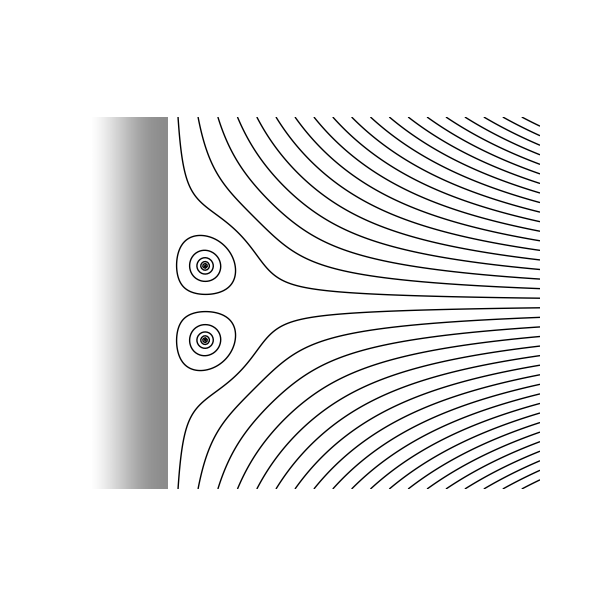

In [25]:
def plot_streamlines(ax, z1, z2, x1 = 0, x2 = 2, y1 = -1, y2 = 1, n_contours = 40, colour = 'black', alpha = 1.0):
    
    # create the meshgrid
    xx = np.linspace(x1, x2, 200)
    yy = np.linspace(y1, y2, 200)
    xx, yy = np.meshgrid(xx, yy)
    zz = xx + 1j * yy

    # get the stream function
    psi = w(zz, z1, z2).imag
    
    # draw the wall
    ax.imshow([[0, 1], [0, 1]], extent=[-0.5, 0, -1, 1], interpolation = 'bicubic', cmap='binary', alpha=1, zorder=2, vmin = 0.1, vmax = 2)
    # plot the contours
    ax.contour(zz.real, zz.imag, psi, colors=colour, levels=np.linspace(-2, 2, n_contours), linewidths = 1, alpha = alpha)
    
# Set the locations of the vortexes
d = np.sqrt(Gamma / 8 / np.pi  / alpha)
z1 = d + 1j*d
z2 = d - 1j*d

# create the figure
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1)
ax.axis('off')
ax.set_aspect('equal')
plot_streamlines(ax, z1, z2)

That looks pretty good, but I'd like to put a heatmap of the pressure field in there, too.  The pressure is related to the velocity by Bernoulli's theorem, and can be written as
$$
p = \text{constant} - \frac{1}{2} \rho \mathbf{u}^2,
$$
where $\mathbf{u}^2 = u^2 + v^2$.  Let's create a function for that (i'll set the constant to zero and the density to one for simplicity):

<IPython.core.display.Javascript object>


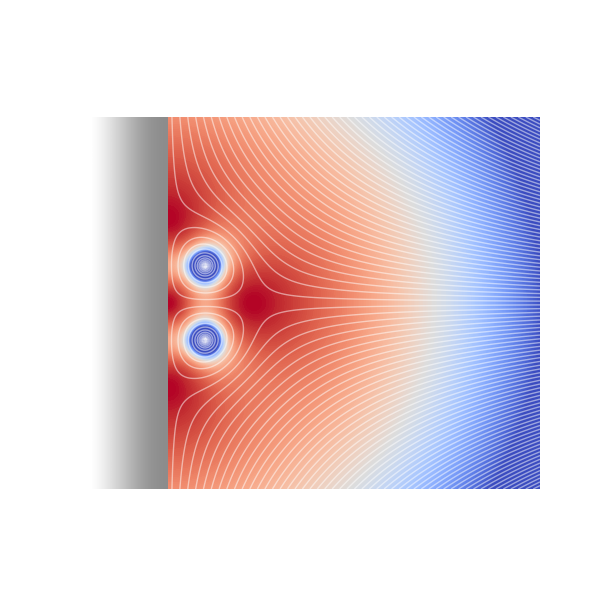

In [26]:
def pressure(z, z1, z2):
    dw = dwdz(z, z1, z2)
    u = dw.real
    v = -dw.imag
    uu = u**2 + v**2
    
    return -0.5 * uu

def plot_pressure(ax, z1, z2, x1 = 0, x2 = 2, y1 = -1, y2 = 1, n_contours = 200):
    
    # create the meshgrid
    xx = np.linspace(x1, x2, 200)
    yy = np.linspace(y1, y2, 200)
    xx, yy = np.meshgrid(xx, yy)
    zz = xx + 1j * yy
    
    # calculate the pressure
    p = pressure(zz, z1, z2)
    
    # But the pressure basically goes to minus infinity at the locations of
    # of the vortexes, so I'm going to cheat and cut that off at some reasonable level.
    # This line makes all values of pressure less than p_cut equal to p_cut
    p_cut = -2
    p[p<p_cut] = p_cut
    
    # draw it
    ax.contourf(zz.real, zz.imag, p, cmap = 'coolwarm', levels = n_contours)
    
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1)
ax.axis('off')
ax.set_aspect('equal')
plot_streamlines(ax, z1, z2, colour='white', n_contours = 100, alpha = 0.5)
plot_pressure(ax, z1, z2)

## Shedding the Vortexes

That looks pretty good!  But now it's time to let the vortexes detach, which we'll do by perturbing them a bit from their position above and then letting them flow with the underlying fluid.

We can find the velocity of each vortex by evaluating the derivative $dw/dz$ at the location of each vortex -- but be careful, we have to remove the vortex itself from the derivative before doing that.  So vortex 1 (the top one) has velocity
$$
u_1 - iv_1 = \left. \frac{dw}{dz} \right|_{z = z_1} = \alpha z + \frac{i\Gamma}{2\pi} \left[ -\frac{1}{z_1 - z_2} - \frac{1}{z_1 + z_1^*} + \frac{1}{z_1 + z_2^*} \right],
$$
and vortex 2 at the bottom has
$$
u_2 - iv_2 = \left. \frac{dw}{dz} \right|_{z = z_2} = \alpha z + \frac{i\Gamma}{2\pi} \left[ \frac{1}{z_2 - z_1} - \frac{1}{z_2 + z_1^*} + \frac{1}{z_2 + z_2^*} \right].
$$

Here are functions for those two derivatives:

In [27]:
def dwdz1(z1, z2):
    return alpha * z1 + 1j*Gamma / 2.0 / np.pi * (- 1 / (z1 - z2) - 1 / (z1 + z1.conjugate()) + 1 / (z1 + z2.conjugate()) )

def dwdz2(z1, z2):
    return alpha * z2 + 1j*Gamma / 2.0 / np.pi * (1 / (z2 - z1) - 1 / (z2 + z1.conjugate()) + 1 / (z2 + z2.conjugate()) )

Once we have the velocities, we can update their positions (and the corresponding mirror vortex positions) using a simple Euler scheme for solving ODEs.  Writing
$$
u = \frac{dx}{dt} \quad \text{and} \quad v = \frac{dy}{dt}
$$
and letting the $d$s becomes $\Delta$s, we get the position update equations
$$
x_{i+1} = x_{i} + \Delta x = x_i + u \Delta t
$$
and
$$
y_{i+1} = y_{i} + \Delta y = y_i + v \Delta t.
$$

We'll need to choose a suitably small timestep $\Delta t$ (which you can try by trial and error if you like), and then we can update the positions, draw the new streamlines, update the positions, draw again, etc.  We'll do this through MatPlotLib's animation interface.

To begin, here's a function that will update the positions of the vortexes.

In [28]:
def update_pos(z1, z2, dt):
    
    x1 = z1.real + dwdz1(z1, z2).real * dt
    y1 = z1.imag - dwdz1(z1, z2).imag * dt
    
    x2 = z2.real + dwdz2(z1, z2).real * dt
    y2 = z2.imag - dwdz2(z1, z2).imag * dt
    
    return x1+1j*y1, x2 + 1j*y2

Now we'll set up the animation itself.  The function "update" is the key: MatPlotLib will call this function repeatedly, and each time it does we'll update the positions of the vortexes.

One issue is the use of outside variables being updated within this function, so we'll use "global" variables -- which have global scope and can be used and changed anywhere -- to set the new positions.

<IPython.core.display.Javascript object>


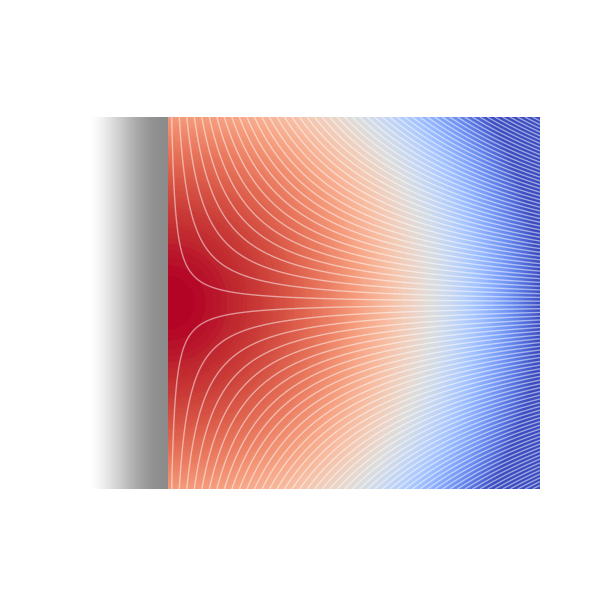

In [31]:
# set up initial conditions
global z1, z2
z1 = 0.21 + 0.2j
z2 = 0.19 - 0.2j
    
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1)
ax.axis('off')
ax.set_aspect('equal')
plot_streamlines(ax, z1, z2, colour='white', n_contours = 100, alpha = 0.5)
plot_pressure(ax, z1, z2)    

t = 0
dt = 0.01

def update(n):
    
    global z1, z2
    z1, z2 = update_pos(z1, z2, dt)
    ax.clear()
    ax.axis('off')
    plot_streamlines(ax, z1, z2, colour='white', n_contours = 100, alpha = 0.5)
    plot_pressure(ax, z1, z2)    
    
anim = animation.FuncAnimation(fig, update, frames=600, interval=1, repeat = False)

#plt.show()
anim.save('basic_animation.mp4', fps=10, extra_args=['-vcodec', 'libx264'])


That's it!  Creating the animation might take a while, but when done will show the two vortexes detach and move downstream as expected.